<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/Time_Series_Forecasting_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Diri

Nama: Mohammad Ripan Saiful Mansur

Linkedin: https://www.linkedin.com/in/mohammad-ripan-b68522141/

Dicoding: https://www.dicoding.com/users/mohrip16/academies

Github: https://github.com/mohripan

# 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint

# 3. Download Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%%shell
cp '/content/gdrive/My Drive/KaggleAPI/kaggle.json' kaggle.json
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d robikscube/hourly-energy-consumption

 96% 11.0M/11.4M [00:01<00:00, 12.4MB/s]
100% 11.4M/11.4M [00:01<00:00, 7.24MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip /content/hourly-energy-consumption.zip -d dataset

Archive:  /content/hourly-energy-consumption.zip
  inflating: dataset/AEP_hourly.csv  
  inflating: dataset/COMED_hourly.csv  
  inflating: dataset/DAYTON_hourly.csv  
  inflating: dataset/DEOK_hourly.csv  
  inflating: dataset/DOM_hourly.csv  
  inflating: dataset/DUQ_hourly.csv  
  inflating: dataset/EKPC_hourly.csv  
  inflating: dataset/FE_hourly.csv   
  inflating: dataset/NI_hourly.csv   
  inflating: dataset/PJME_hourly.csv  
  inflating: dataset/PJMW_hourly.csv  
  inflating: dataset/PJM_Load_hourly.csv  
  inflating: dataset/est_hourly.paruqet  
  inflating: dataset/pjm_hourly_est.csv  


# 4. Exploratory Data Analysis

In [6]:
df = pd.read_csv('dataset/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [7]:
print(df.head())

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [8]:
# Convert to datetime and set the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Sort the DataFrame by the datetime index
df.sort_index(inplace=True)

missing_values = df.isnull().sum()
missing_values

AEP_MW    0
dtype: int64

In [9]:
summary_statistics = df.describe()
summary_statistics

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


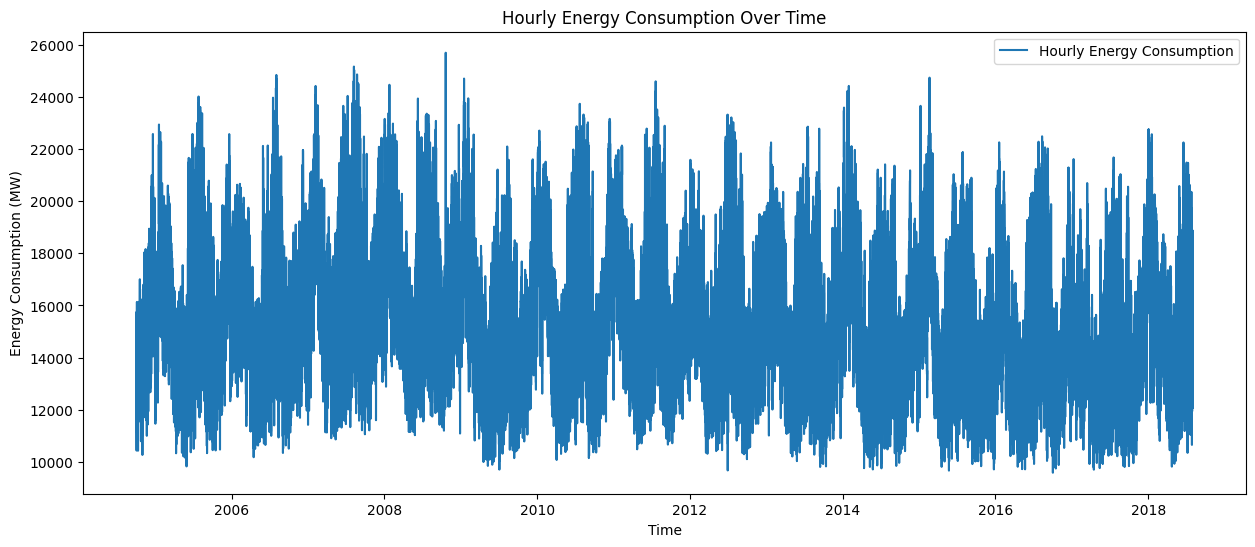

In [10]:
# Plotting the time series
plt.figure(figsize=(15, 6))
plt.plot(df['AEP_MW'], label='Hourly Energy Consumption')
plt.title('Hourly Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

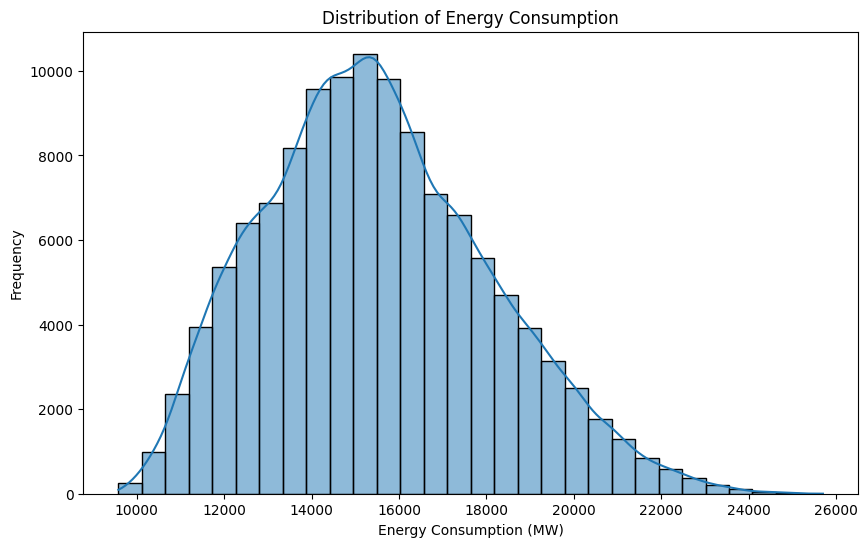

In [11]:
# Histogram of the data
plt.figure(figsize=(10, 6))
sns.histplot(df['AEP_MW'], bins=30, kde=True)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.show()

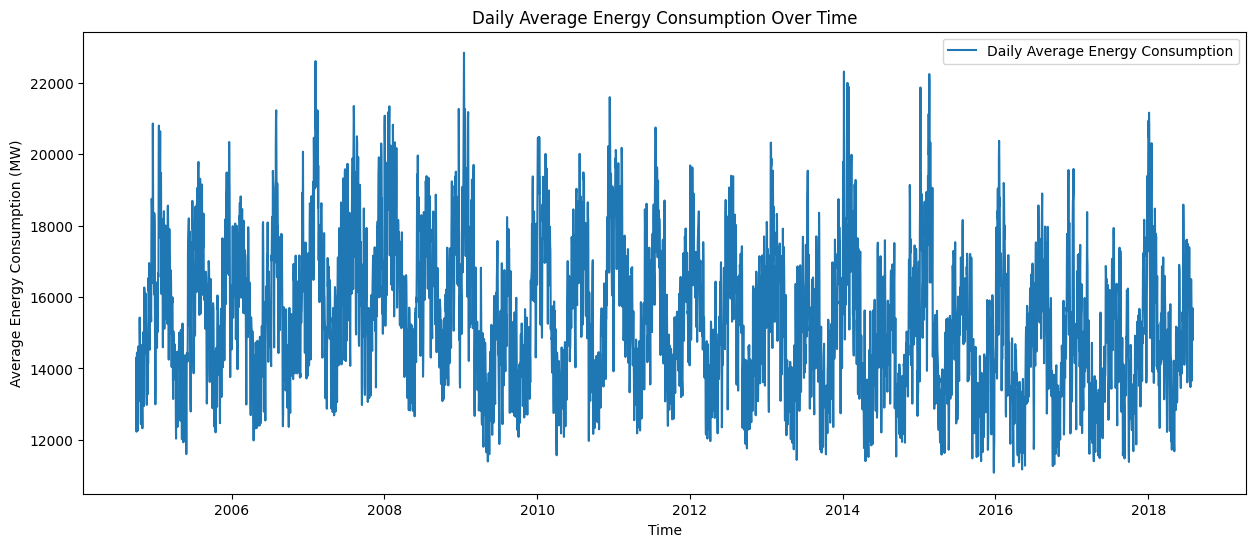

In [12]:
# Convert hourly data to daily data by taking the average
daily_data = df.resample('D').mean()

# Plotting the daily time series
plt.figure(figsize=(15, 6))
plt.plot(daily_data['AEP_MW'], label='Daily Average Energy Consumption')
plt.title('Daily Average Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Average Energy Consumption (MW)')
plt.legend()
plt.show()

In [13]:
len(daily_data)

5055

# 5. Data Preprocessing

In [48]:
data = df.copy()

# Extract features from the DateTime index
data['hour'] = data.index.hour
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year

# Create cyclical features for 'hour', 'day_of_week', 'month', 'season'
data['hour_sin'] = np.sin(data['hour'] * (2. * np.pi / 24))
data['hour_cos'] = np.cos(data['hour'] * (2. * np.pi / 24))

data['day_sin'] = np.sin(data['day'] * (2. * np.pi / 30)) # Approximate with 30 days per month
data['day_cos'] = np.cos(data['day'] * (2. * np.pi / 30))

data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2. * np.pi / 7))
data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2. * np.pi / 7))

data['month_sin'] = np.sin((data['month'] - 1) * (2. * np.pi / 12))
data['month_cos'] = np.cos((data['month'] - 1) * (2. * np.pi / 12))

# Season feature: Winter=1, Spring=2, Summer=3, Fall=4
data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2] else
                                                2 if x in [3, 4, 5] else
                                                3 if x in [6, 7, 8] else
                                                4)

# Transform 'season' into sine and cosine components
data['season_sin'] = np.sin((data['season'] - 1) * (2. * np.pi / 4))
data['season_cos'] = np.cos((data['season'] - 1) * (2. * np.pi / 4))

# Drop the original categorical columns
data = data.drop(['hour', 'day', 'day_of_week', 'month', 'season'], axis=1)

In [49]:
train_df, val_df = train_test_split(data, test_size=0.2, shuffle=False)

In [50]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale 'AEP_MW' and 'year'
train_scaled = train_df.copy()
val_scaled = val_df.copy()
train_scaled[['AEP_MW', 'year']] = scaler.fit_transform(train_scaled[['AEP_MW', 'year']])
val_scaled[['AEP_MW', 'year']] = scaler.transform(val_scaled[['AEP_MW', 'year']])

# For future purpose
train_df_copy = train_df.copy()

train_df = pd.DataFrame(train_scaled, index=train_scaled.index, columns=train_scaled.columns)
val_df = pd.DataFrame(val_scaled, index=val_scaled.index, columns=val_scaled.columns)

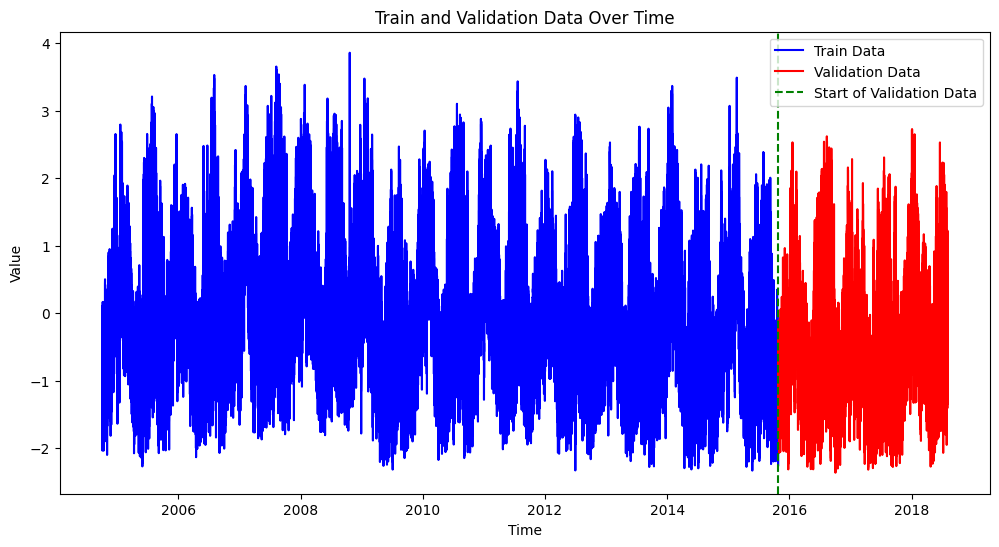

In [51]:
train_end = train_df.index[-1]
val_start = val_df.index[0]

plt.figure(figsize=(12, 6))

# Plotting train_df in blue
plt.plot(train_df.index, train_df['AEP_MW'], color='blue', label='Train Data')

# Plotting val_df in red
plt.plot(val_df.index, val_df['AEP_MW'], color='red', label='Validation Data')

# Drawing a vertical line at the boundary between train and validation data
plt.axvline(x=val_start, color='green', linestyle='--', label='Start of Validation Data')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Train and Validation Data Over Time')
plt.legend()
plt.show()

# 6. Build Model

In [52]:
class CustomCallback(Callback):
  def __init__(self, threshold, passed_filepath, best_filepath):
    super(CustomCallback, self).__init__()
    self.threshold = threshold
    self.best_mae = float('inf')
    self.passed_filepath = passed_filepath
    self.best_filepath = best_filepath

  def on_epoch_end(self, epoch, logs=None):
    current_mae = logs.get('val_mae')
    if current_mae < self.threshold:
      print(f"Epoch {epoch + 1}: Saving model as current MAE {current_mae} is lower than threshold {self.threshold}")
      self.model.save(self.passed_filepath)
    if current_mae < self.best_mae:
      print(f"Epoch {epoch + 1}: Saving new best model with MAE {current_mae}")
      self.model.save(self.best_filepath)
      self.best_mae = current_mae

In [53]:
max_scale = train_df['AEP_MW'].max()
min_scale = train_df['AEP_MW'].min()
mae_threshold = 0.10 * (max_scale - min_scale)  # 10% from scale data

custom_callback = CustomCallback(mae_threshold, 'passed_model.keras', 'best_model.keras')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [54]:
def create_sequences(data, n_steps):
  X, y = [], []
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data.iloc[i:end_ix, :-1], data.iloc[end_ix, 0]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

n_steps = 24  # One day

X_train, y_train = create_sequences(train_df, n_steps)
X_val, y_val = create_sequences(val_df, n_steps)

In [55]:
# Define the LSTM model
model = Sequential([
    LSTM(10, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [56]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[custom_callback, early_stopping, reduce_lr])

Epoch 1/10
3031/3032 [============================>.] - ETA: 0s - loss: 0.1204 - mae: 0.2468Epoch 1: Saving model as current MAE 0.10029896348714828 is lower than threshold 0.6190171172730583
Epoch 1: Saving new best model with MAE 0.10029896348714828
3032/3032 [==============================] - 23s 7ms/step - loss: 0.1204 - mae: 0.2468 - val_loss: 0.0163 - val_mae: 0.1003 - lr: 0.0010
Epoch 2/10
3028/3032 [============================>.] - ETA: 0s - loss: 0.0446 - mae: 0.1556Epoch 2: Saving model as current MAE 0.07418706268072128 is lower than threshold 0.6190171172730583
Epoch 2: Saving new best model with MAE 0.07418706268072128
3032/3032 [==============================] - 21s 7ms/step - loss: 0.0445 - mae: 0.1555 - val_loss: 0.0091 - val_mae: 0.0742 - lr: 0.0010
Epoch 3/10
3027/3032 [============================>.] - ETA: 0s - loss: 0.0387 - mae: 0.1434Epoch 3: Saving model as current MAE 0.07014184445142746 is lower than threshold 0.6190171172730583
Epoch 3: Saving new best model

# 7. Model Evaluation

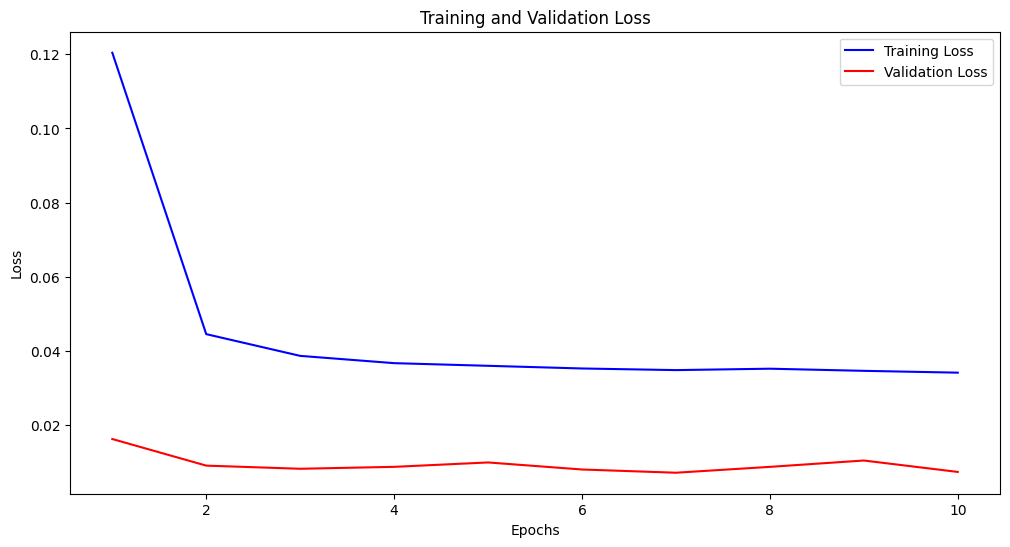

In [57]:
# Extracting loss and MAE for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

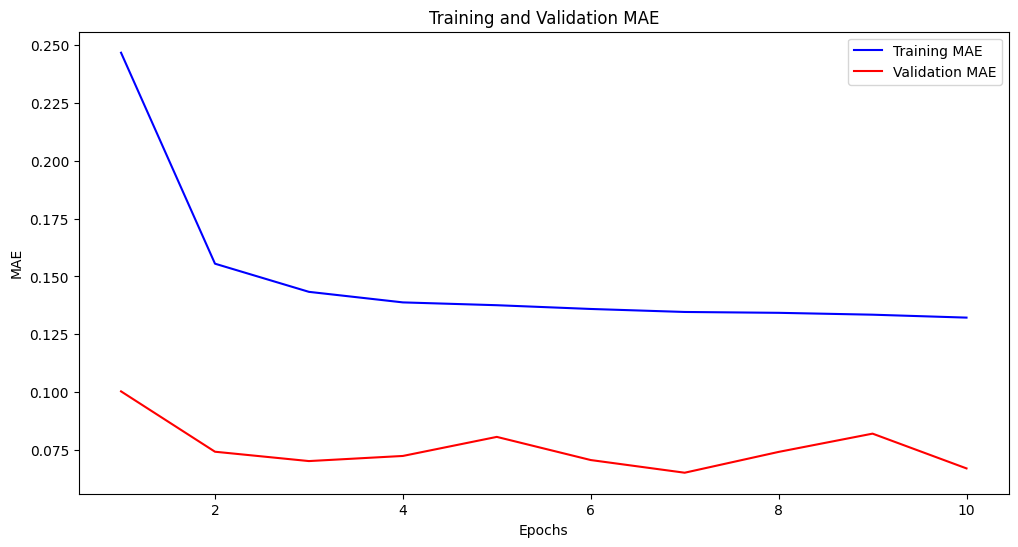

In [58]:
# Plotting training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [59]:
# Load the saved model
loaded_model = tf.keras.models.load_model('best_model.keras')

In [60]:
# Make predictions
train_predictions = loaded_model.predict(X_train)
val_predictions = loaded_model.predict(X_val)

758/758 [==============================] - 2s 3ms/step


In [61]:
# Creating separate scalers for 'AEP_MW' and 'year'
aep_mw_scaler = StandardScaler()
year_scaler = StandardScaler()

# Fit the scalers on respective columns
aep_mw_scaler.fit(train_df_copy[['AEP_MW']])
year_scaler.fit(train_df_copy[['year']])

# Inverse transform the 'AEP_MW' predictions
train_predictions_aep_mw = aep_mw_scaler.inverse_transform(train_predictions.reshape(-1, 1)).ravel()
val_predictions_aep_mw = aep_mw_scaler.inverse_transform(val_predictions.reshape(-1, 1)).ravel()

# Extracting the scaled 'year' values from train and validation sets
train_years_scaled = train_df.iloc[(n_steps - 1):-1, data.columns.get_loc('year')]
val_years_scaled = val_df.iloc[(n_steps - 1):-1, data.columns.get_loc('year')]

# Inverse transform the scaled 'year' values
train_years = year_scaler.inverse_transform(train_years_scaled.values.reshape(-1, 1)).ravel()
val_years = year_scaler.inverse_transform(val_years_scaled.values.reshape(-1, 1)).ravel()

# Inverse transform the actual 'AEP_MW' targets
y_train_inv = aep_mw_scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_val_inv = aep_mw_scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()

# Calculate MAE
train_mae = mean_absolute_error(y_train_inv, train_predictions_aep_mw)
val_mae = mean_absolute_error(y_val_inv, val_predictions_aep_mw)

# Calculate the threshold (10% of the scale of the original 'AEP_MW')
threshold = 0.10 * (df['AEP_MW'].max() - df['AEP_MW'].min())

print(f"Training MAE: {train_mae}, Validation MAE: {val_mae}, Threshold: {threshold}")

Training MAE: 187.65681543445987, Validation MAE: 168.62322227015497, Threshold: 1611.4


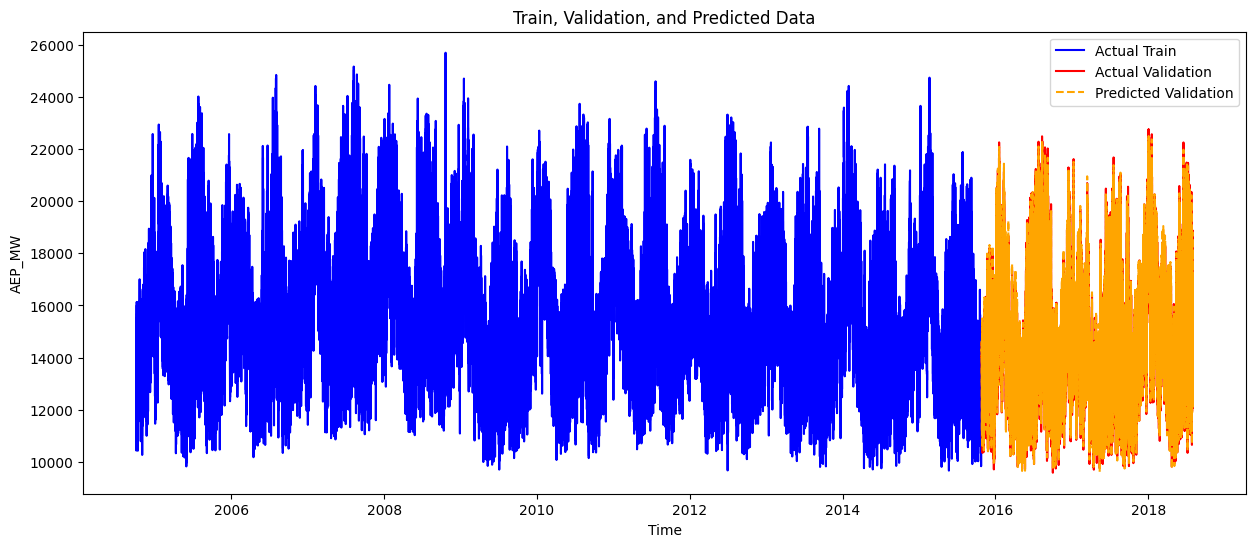

In [62]:
# For train and validation, we use the existing index after trimming
train_index = train_df.index[(n_steps - 1):-1]
val_index = val_df.index[(n_steps - 1):-1]

# Plotting
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_index, y_train_inv, label='Actual Train', color='blue')

# Plot validation data
plt.plot(val_index, y_val_inv, label='Actual Validation', color='red')

# Plot predictions for training and validation data
plt.plot(val_index, val_predictions_aep_mw, label='Predicted Validation', color='orange', alpha=1, linestyle='--')

plt.title('Train, Validation, and Predicted Data')
plt.xlabel('Time')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()